Section 1: Load the needed libraries

In [1]:
import networkx as nx
import pandas as pd
from pathlib import Path
from networkx.algorithms import community
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


projected_dir = Path("../data/networks/projected")
output_dir = Path("../data/results")
output_dir.mkdir(parents=True, exist_ok=True)

repos = ["scikit-learn", "pytorch", "kubernetes", "apache-spark"]
phases = ["pre", "during", "post"]




Section 2: Create the Global Metrics

In [2]:
def calculate_metrics(G):
    metrics = {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_clustering": nx.average_clustering(G),
    }

    # Modularity using Louvain if possible
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
    except ImportError:
        modularity = None
    metrics["modularity"] = modularity

    return metrics


global_results = []

for repo in repos:
    for phase in phases:
        graph_path = projected_dir / f"{repo}_{phase}_projected.gml"
        if not graph_path.exists():
            print(f"Missing: {graph_path}")
            continue

        G = nx.read_gml(graph_path)
        print(f"Loaded graph: {repo} ({phase}) with {G.number_of_nodes()} nodes")

        # Global metrics
        gm = calculate_metrics(G)
        gm["repo"] = repo
        gm["phase"] = phase

        global_results.append(gm)

global_df = pd.DataFrame(global_results)
global_df.to_csv(output_dir / "global_metrics.csv", index=False)
global_df


Loaded graph: scikit-learn (pre) with 95 nodes
Loaded graph: scikit-learn (during) with 131 nodes
Loaded graph: scikit-learn (post) with 35 nodes
Loaded graph: pytorch (pre) with 359 nodes
Loaded graph: pytorch (during) with 803 nodes
Loaded graph: pytorch (post) with 365 nodes
Loaded graph: kubernetes (pre) with 1160 nodes
Loaded graph: kubernetes (during) with 1430 nodes
Loaded graph: kubernetes (post) with 423 nodes
Loaded graph: apache-spark (pre) with 172 nodes
Loaded graph: apache-spark (during) with 202 nodes
Loaded graph: apache-spark (post) with 76 nodes


,num_nodes,num_edges,density,avg_clustering,modularity,repo,phase
0,95,138,0.030907,0.259662,0.476166,scikit-learn,pre
1,131,189,0.022196,0.200871,0.498078,scikit-learn,during
2,35,52,0.087395,0.146604,0.363206,scikit-learn,post
3,359,2498,0.038873,0.696226,0.241106,pytorch,pre
4,803,8090,0.025124,0.572704,0.408984,pytorch,during
5,365,4539,0.068328,0.661742,0.381465,pytorch,post
6,1160,18491,0.027507,0.672398,0.337554,kubernetes,pre
7,1430,18550,0.018155,0.661403,0.361694,kubernetes,during
8,423,4072,0.045623,0.652579,0.380985,kubernetes,post
9,172,388,0.026384,0.302493,0.609793,apache-spark,pre


Section 3: Create the Node Level Metrics

In [3]:
# Node-level metrics
node_results = []

for repo in repos:
    for phase in phases:
        graph_path = projected_dir / f"{repo}_{phase}_projected.gml"
        if not graph_path.exists():
            continue

        G = nx.read_gml(graph_path)
        strength_dict = dict(G.degree(weight="weight"))
        degree_dict = dict(G.degree())
        betweenness_dict = nx.betweenness_centrality(G, weight="weight", normalized=True)

        for node in G.nodes():
            node_results.append({
                "repo": repo,
                "phase": phase,
                "node": node,
                "degree": degree_dict.get(node, 0),
                "strength": strength_dict.get(node, 0),
                "betweenness": betweenness_dict.get(node, 0)
            })

node_df = pd.DataFrame(node_results)
node_df.to_csv(output_dir / "node_metrics.csv", index=False)
node_df.head()


,repo,phase,node,degree,strength,betweenness
0,scikit-learn,pre,kiote,1,2,0.000000
1,scikit-learn,pre,TomDLT,15,50,0.160451
2,scikit-learn,pre,jjerphan,1,2,0.000000
3,scikit-learn,pre,GaelVaroquaux,26,110,0.298292
4,scikit-learn,pre,wconnell,1,2,0.000000


Section 4: Summarize the Node Level Results

In [4]:
# Load the node metrics CSV file
node_metrics = pd.read_csv("../data/results/node_metrics.csv")

# Compute descriptive statistics per repository and phase
summary_stats = (
    node_metrics
    .groupby(["repo", "phase"])
    .agg({
        "degree": ["mean", "median", "max", "std"],
        "strength": ["mean", "median", "max", "std"],
        "betweenness": ["mean", "median", "max", "std"]
    })
    .reset_index()
)

# Flatten the multi-index columns
summary_stats.columns = ["_".join(col).strip("_") for col in summary_stats.columns]

# Save the summary as a CSV file
output_path = Path("../data/results/node_metrics_summary.csv")
summary_stats.to_csv(output_path, index=False)

# Optional: Preview the summary
summary_stats.head()


,repo,phase,degree_mean,degree_median,degree_max,degree_std,strength_mean,strength_median,strength_max,strength_std,betweenness_mean,betweenness_median,betweenness_max,betweenness_std
0,apache-spark,during,3.346535,2.0,26,4.213071,11.366337,5.0,119,17.538145,0.014775,0.000000,0.259322,0.036587
1,apache-spark,post,2.710526,2.0,12,2.398976,9.368421,6.0,64,11.711922,0.027064,0.000000,0.335075,0.055883
2,apache-spark,pre,4.511628,2.0,48,6.311123,20.488372,5.0,255,38.310441,0.012311,0.000172,0.195813,0.030148
3,kubernetes,during,25.944056,6.0,617,55.216030,211.436364,15.0,13470,735.752436,0.001331,0.000064,0.068712,0.004380
4,kubernetes,post,19.252955,7.0,184,28.648298,119.905437,21.0,2246,257.023005,0.004225,0.000399,0.080597,0.009435


Section 5: Visualization

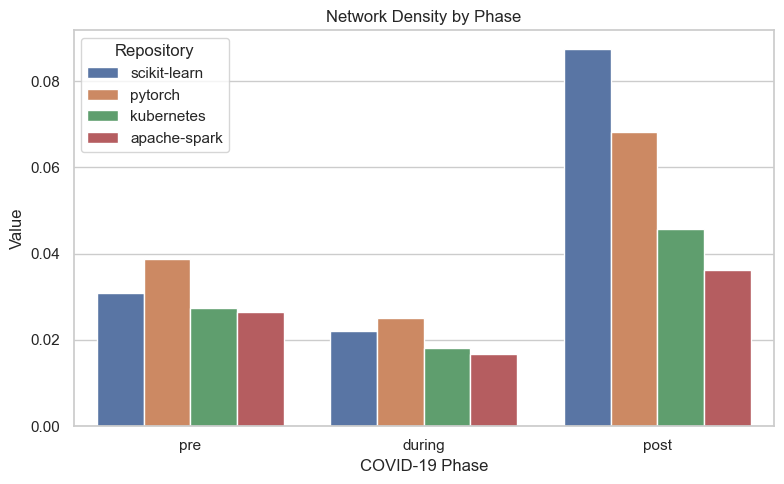

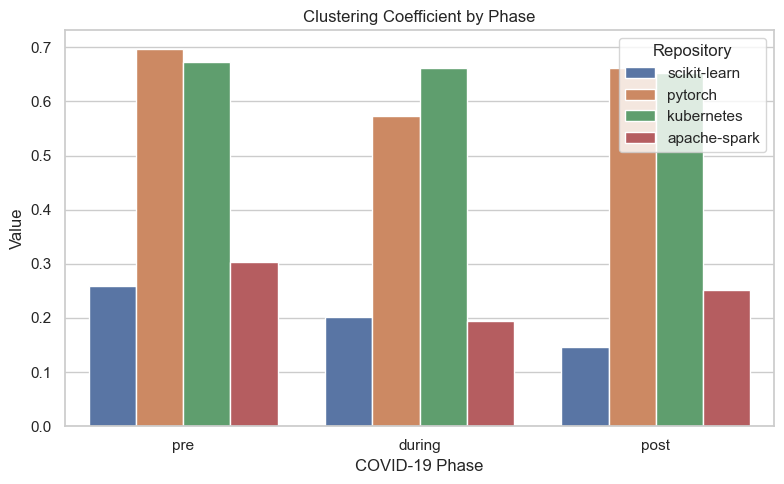

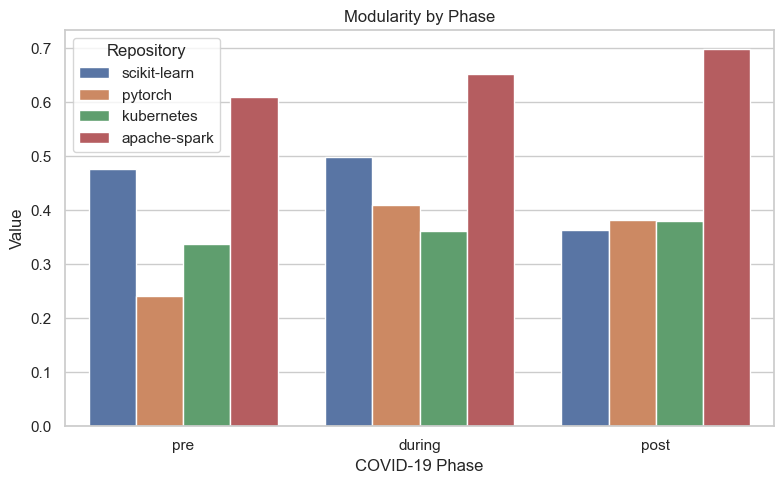

In [7]:
# Set a consistent style
sns.set(style="whitegrid")

# Define metrics and titles
metrics = ['density', 'avg_clustering', 'modularity']
titles = ['Network Density by Phase', 'Clustering Coefficient by Phase', 'Modularity by Phase']
filenames = ['density_plot.png', 'clustering_plot.png', 'modularity_plot.png']

# Plot each metric individually
for metric, title, filename in zip(metrics, titles, filenames):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=global_df,
        x='phase',
        y=metric,
        hue='repo'
    )
    plt.title(title)
    plt.xlabel('COVID-19 Phase')
    plt.ylabel('Value')
    plt.legend(title='Repository')
    plt.tight_layout()
    plt.savefig(f'../figures/results/{filename}', dpi=300)
 
    plt.show()
